# Detecting anomalous entries in the daily website data

Importing Packages ...

In [250]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as pyplot
from pmdarima import auto_arima
import numpy as np
from tbats import TBATS
import warnings
warnings.filterwarnings('ignore')
import csv

Reading data and writing into pandas dataframe

In [251]:
df=pd.read_csv('daily_revenue.csv')

In [252]:
df.head(3)

,date,site,revenue,pageviews
0,2016-07-13,wearewearside,0.539353,389
1,2016-07-13,projectspurs,3.588072,2353
2,2016-07-13,totalbarca,5.130714,1228


Calculating CPM and adding it as another column

In [253]:
df['cpm']=df['revenue']/df['pageviews']*1000

In [277]:
df.head(3)

,date,site,revenue,pageviews,cpm
date,,,,,
2016-07-13,2016-07-13,wearewearside,0.539353,389,1.386513
2016-07-13,2016-07-13,projectspurs,3.588072,2353,1.524892
2016-07-13,2016-07-13,totalbarca,5.130714,1228,4.178106


## Exploratory data analysis to make decisions

In [254]:
df.dtypes

date          object
site          object
revenue      float64
pageviews      int64
cpm          float64
dtype: object

Converting date to datetime and setting it as an index of the dataframe

In [255]:
df['date'] = pd.to_datetime(df['date'])

In [256]:
df.index = df['date']

In [279]:
df.head(3)

,date,site,revenue,pageviews,cpm
date,,,,,
2016-07-13,2016-07-13,wearewearside,0.539353,389,1.386513
2016-07-13,2016-07-13,projectspurs,3.588072,2353,1.524892
2016-07-13,2016-07-13,totalbarca,5.130714,1228,4.178106


In [258]:
len(df['site'].unique())

173

The dataset contains data of 173 websites

In [259]:
len(df)

17747

and more than 17000 rows for all the websites

### Possible approaches which I thought:

1) Setting some benchmark at the lower and upper side. If the value goes below the benchmark, it is underperforming and overperforming if it goes above upper limit

In this case, I was thinking of keeping the same limits for the whole data

The possible limits could be:<br>
1) Mean+/-2 SD<br>
2) Mean+/-1 SD<br>
3) Median+/-1/2 SD<br>
4) Some quartile +/- n SD<br>

Before deciding the benchmark, lets have a look at mean of indivitual website to see if the websites are performing in the same pattern

In [263]:
df.groupby('site')['cpm'].mean()

site
1899.me                            0.093188
49erswebzone                       4.331825
allarsenal                         1.138935
allhabs                            0.908335
angelswin                          0.993262
arseblog                           1.784145
arsenal-mania                      1.823034
autoblog                           3.561233
autoweek                          14.899640
billboard                          0.762277
birdgang                           0.974331
blackandbluereview                 0.602298
bluemoon-mcfc                     19.165804
buffalofambase                     1.134076
captainamericalibrary              0.704287
cardinalconnect                    1.062456
catchronicles                      1.247632
celticquicknews                   33.329765
chicagoreader                      1.352614
chicitysports                      0.974646
cityweekly                         1.286510
claretandhugh                      3.529006
comcastsportsnet           

Looks like mean is varrying a lot for all the websites. We need to consider every website independantly. We can't use same benchmark for all the websites

Mean+/-2SD is the most prefered benchmark. If the data is normally distributed, this range will cover more than 95% of data and only 2% of data from both the ends will be taken as an anomaly

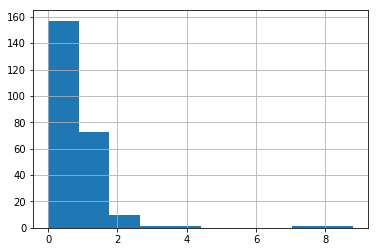

In [280]:
df[df['site']=='wearewearside']['cpm'].hist()

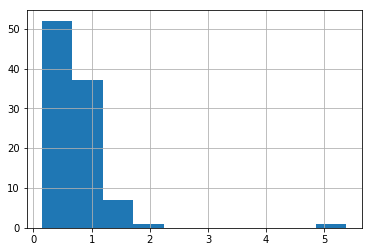

In [281]:
df[df['site']=='projectspurs']['cpm'].hist()

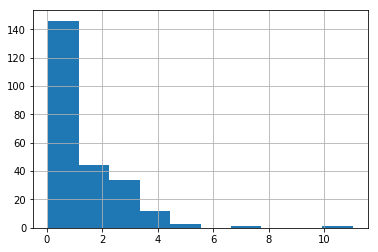

In [283]:
df[df['site']=='totalbarca']['cpm'].hist()

But, after ploting histograms for 3 different websites, I found that the data isn't normally distributed. For majority of websites. And so 2 SD is a bad idea for benchmark.

In [264]:
df.groupby('site')['cpm'].std()

site
1899.me                              0.089287
49erswebzone                        26.996430
allarsenal                           0.835546
allhabs                              0.540100
angelswin                            2.810032
arseblog                             1.315703
arsenal-mania                        0.896359
autoblog                            22.181989
autoweek                            90.014235
billboard                            0.263585
birdgang                             0.731949
blackandbluereview                   0.435257
bluemoon-mcfc                      179.474972
buffalofambase                       0.690547
captainamericalibrary                0.610333
cardinalconnect                      0.969231
catchronicles                        2.111573
celticquicknews                    225.608256
chicagoreader                        1.407348
chicitysports                        0.524536
cityweekly                           4.897971
claretandhugh                

Also, after reviewing SD for the websites indivitually, I found out that SD is sometimes higher or almost equal to the mean. So, using -SD on the lower side will set -ve benchmark and we wont be able to filter out low abnormalities.

In [284]:
df.groupby('site')['cpm'].count()

site
1899.me                            14
49erswebzone                       98
allarsenal                         17
allhabs                           116
angelswin                         163
arseblog                          195
arsenal-mania                     123
autoblog                          103
autoweek                          163
billboard                           4
birdgang                           78
blackandbluereview                  3
bluemoon-mcfc                     128
buffalofambase                    107
captainamericalibrary              99
cardinalconnect                   205
catchronicles                     195
celticquicknews                   130
chicagoreader                     123
chicitysports                     212
cityweekly                        203
claretandhugh                     116
comcastsportsnet                  168
cornellsun                        190
csgoutpost                         76
cyclonefanatic                    108
dailyth

Also the websites have variety of number of entires in the entire year which made me decide that the same method will also not work for all the websites. Let's check if we can categorize websites based on their density and ranges and then set same method based on their categories.

In [266]:
df.groupby('site')['cpm'].agg(lambda x: [x.min(), x.max()])

site
1899.me                                [0.013113133856273843, 0.341232290648395]
49erswebzone                            [0.12822055061724533, 259.5526074120139]
allarsenal                              [0.12080135004621072, 3.366575486926605]
allhabs                                [0.24265430364884935, 3.1072654672501256]
angelswin                           [0.00027386343348078854, 35.858120835188004]
arseblog                             [0.0021451612903225807, 15.641777851326218]
arsenal-mania                          [0.49899685003733535, 6.5832619614406775]
autoblog                             [0.0001700487719365529, 225.73524046666668]
autoweek                                 [0.3356316844495598, 683.9235931797713]
billboard                                  [0.48296523072696, 1.119201840914009]
birdgang                               [0.006416666666666667, 3.111247555692987]
blackandbluereview                                [0.1451625, 1.011749915238095]
bluemoon-mcfc          

The CPM also has wide ranges for some websites and very narrow ranges for some of the websites. I was thinking of categorizing the websites based on their counts and then setting same benchmarks for all the websites in the same category. But, that won't work either and I will have to treat every website differently.

### Checking for the seasonality

The problem statement suggests that the CPM value has seasonality. Let's check it by segmenting dates.

In [287]:
df.groupby(df.index.weekday_name)['cpm'].mean()

date
Friday       3.473072
Monday       7.856015
Saturday     4.761855
Sunday       6.192017
Thursday     1.627096
Tuesday      1.153213
Wednesday    1.414272
Name: cpm, dtype: float64

We can see CPM is higher on weekends along with the monday. Lets check if the same trend is followed for all the websites.

In [288]:
df.groupby(['site',df.index.weekday_name])['cpm'].mean()

site                            date     
1899.me                         Friday         0.070303
                                Monday         0.126731
                                Saturday       0.176307
                                Sunday         0.070835
                                Thursday       0.055238
                                Tuesday        0.049459
                                Wednesday      0.040019
49erswebzone                    Friday         5.880898
                                Monday         1.361022
                                Saturday      19.435499
                                Sunday         0.769048
                                Thursday       1.023657
                                Tuesday        0.854273
                                Wednesday      0.983088
allarsenal                      Friday         0.718129
                                Monday         1.811940
                                Saturday       0.899868
      

It is observed that, CPM is highest on saturday or sunday for most of the websites. So, we can conclude that there is seasonality in the weeks

Lets check monthly seasonality

In [290]:
df.groupby(df.index.month)['cpm'].mean()

date
1       0.790483
2       9.162090
3       0.437058
4       0.558376
5       0.837326
7       0.827957
8       0.525827
10    102.438013
11      2.318686
12      1.841249
Name: cpm, dtype: float64

In [291]:
df.groupby(df.index.month)['cpm'].count()

date
1     2390
2     2045
3     2823
4     2892
5     2894
7      115
8      164
10     316
11    1745
12    2363
Name: cpm, dtype: int64

CPM doesn't have any trend in the months. Also the variety is there because number of observations are very diverse along the months

In [269]:
df.groupby(['site',df.index.month])['cpm'].mean()

site                            date
1899.me                         3          0.043382
                                4          0.130543
49erswebzone                    2         57.154853
                                3          0.579537
                                4          0.892381
                                5          1.188794
allarsenal                      2          1.138935
allhabs                         1          0.382954
                                2          0.737352
                                10         0.785359
                                11         1.303616
                                12         1.169621
angelswin                       1          0.002383
                                2          2.765178
                                3          0.625081
                                4          0.429425
                                5          0.709199
                                10         1.122554
                           

On the website level, I observed that mean CPM is lower for the months january, july, april and october for some of the websites. (the same thing is stated in the problem statement as well) So, I think there is seasonality by the quarters.

In [270]:
pd.set_option("display.max_rows", 1000)


In [271]:
dates=pd.date_range(df.index[0],df.index[-1])

In [272]:
dates

DatetimeIndex(['2016-07-13', '2016-07-14', '2016-07-15', '2016-07-16',
               '2016-07-17', '2016-07-18', '2016-07-19', '2016-07-20',
               '2016-07-21', '2016-07-22',
               ...
               '2017-05-22', '2017-05-23', '2017-05-24', '2017-05-25',
               '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29',
               '2017-05-30', '2017-05-31'],
              dtype='datetime64[ns]', length=323, freq='D')

Creating a dictionary where key represents site name and value represents corressponding dataframe which has only data for the same websites. (splited data by websites)

In [273]:
dict_of_sites = dict(tuple(df.groupby("site")))

So I concluded that the data has weekly seasonality and statistical approach won't work here. 

Now, I had multiple options to find anomalies in the data.<br>
1) Classification<br>
2) Clustering<br>
3) Time series<br>

We can use single class classification in this case. Possible algorithms could be SVM, logistic regression, artificial neural networks which can provide non-linear boundaries on the normalized data. But, in this case, labels aren't provided and manually labeling 17000 entries is not feasible option. 

We can use k-means clustering with k=2 or 3. Now, 3 clusters will be formed. The points which are present at the extreme ends and far from the centroid of normal(non-anomalous) datapoints will be detected and clustered differently. But, clustering algorithm won't detect the seasonalities. For example, at the start of every quarter, CPM tends to be low. But, clustering won't consider this fact and still cluster these low CPM points as the anomaly.

To consider the seasonality, best way is use time-series analysis/forecasting. 

Possible options were:<br>
1) AR<br>
2) MA<br>
3) ARMA<br>
4) ARIMA<br>
5) SARIMA<br>
6) SARIMAX<br>
6) TBATS<br>


As we have concluded out model contains at least 1 seasonality (weekly) and so we will have to convert out our non-stationary data to stationary time series. Also these models won't handle seasonal data well. So, the remaining options are TBATS, SARIMA, SARIMAX 

BATS model is Exponential Smoothing Method + Box-Cox Transformation + ARMA model for residuals. The Box-Cox Transformation here is for dealing with non-linear data and ARMA model for residuals can de-correlated the time series data. Alysha M.(2010) has proved that BATS model can improve the prediction performance compared to the simple Sate Space Model. However, BATS model does not do well when the the seaonality is complex and high frequency. So, Alysha M.(2011) propsed TBATS model which is BATS model + Trigonometric Seasonal. The trigonometric expression of seasonality terms can not only dramatically reduced the parameters of model when the frequencies of seaonalities are high but also give the model more flexibility to deal with complex seasonality. In a nutshell, this is how the story goes: Exponential Smoothing Method ⇒ State Space Model ⇒ BATS ⇒ TBATS.



source:https://yintingchou.com/posts/bats-and-tbats-model/

There is dedicated python package which is used to implement TBATS. 

In [133]:
estimator = TBATS(seasonal_periods=(7,90))
model = estimator.fit(train)
# Forecast 60 days ahead
y_forecast = model.forecast(steps=60)

In [49]:
y_forecast

array([0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149,
       0.69041149, 0.69041149, 0.69041149, 0.69041149, 0.69041149])

In [295]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: []
Seasonal harmonics []
ARMA errors (p, q): (4, 0)
Smoothing (Alpha): 0.491055
Seasonal Parameters (Gamma): []
AR coefficients [-0.19286357 -0.14301821 -0.169737    0.30588681]
MA coefficients []
Seed vector [5.75247639e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]

AIC 953.899533


I played around the data for seasonality terms,(tried s1=7 and s2=15,30,60,90). s2=90 gave the closed prediction for 2-3 websites. However, after reviewing the results I realized that the data isn't enough and not even 3 seasons for quarterly seasonality is present to detect seasonalities and predict multiple outputs. As, for most of the websites values are not present and so TBATS isn't working properly. AIC is also very high.

Now lets consider SARIMA. This model works well with single seasonality but can't handle multiple seasonalities. So, I had to consider SARIMAX. X denotes exogenous term. So, in terms for SARIMAX, multiple seasonalities are handled using exogenous dataset. So, one of the seasonality is handled by exogenous dataset using fourier transformation. Another seasonality is handled by SARIMA model.

After playing around multiple websites by varying number of fourier terms (upto 5), I observed that the model gave best predictions for some websites with 2 fourier terms. 

In [296]:
def sarima(d,train,test):
    # prepare Fourier terms
    exog = pd.DataFrame({'date': d.index})
    exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='D'))
    exog['sin90'] = np.sin(2 * np.pi * exog.index.dayofyear / 90)
    exog['cos90'] = np.cos(2 * np.pi * exog.index.dayofyear / 90)
    exog['sin90_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 90)
    exog['cos90_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 90)
    exog = exog.drop(['date'],axis=1)
    exog_to_train=exog[(pd.to_datetime(d.index) < '2017-04-01')]
    #exog_to_test=exog[(pd.to_datetime(d.index) >= '2017-04-01')]

    # Fit model
    arima_exog_model = auto_arima(y=train, exogenous=exog_to_train, seasonal=True, m=7)
    # Forecast
    y_arima_exog_forecast = arima_exog_model.predict(n_periods=len(test), exogenous=test)
    return y_arima_exog_forecast

Data before 04/01 is used for fitting the model. Data after that is used to test the model. (The data transformation part is exluded from the notebook to avoid confusion)

In this case, I predicted the future outcomes for test data. The future outcomes are expected CPM values considering seasonalities and trends in the CPM data over a year (actually dataset contains values less than the year).
If the residuals between actual and expected values are larger than some benchmark, then for that day, data will be  said abnormal


In [293]:
countDic=pd.DataFrame(columns=['low','high'])

In [351]:
performanceDF=pd.DataFrame(columns=['non-zero','zero'])

In [352]:
with open("Notifications.csv", "w") as csvFile:
    fieldnames = ['Site','Date','Expected CPM','Actual CPM','Abnormality','Percentage Drop/Growth']
    writer = csv.DictWriter(csvFile, fieldnames=fieldnames)
    writer.writeheader()
    for k in dict_of_sites:
#         print('###################################################')
        d=dict_of_sites[k]
        d=d[['cpm']]
        low=0
        high=0
        nonzero=(d['cpm'].mean())
#         print('\033[1m',k,'\033[0m'+' has ',len(d),' entries')
        d=d.reindex(dates,fill_value=0)
        zero=float(d['cpm'].mean())
        performanceDF.loc[k]=[nonzero,zero]
        train=d[(pd.to_datetime(d.index) < '2017-04-01')]
        test=d[(pd.to_datetime(d.index) >= '2017-04-01')]
        if len(train[train['cpm']!=0])<0.2*len(train) or len(test[test['cpm']!=0])==0:
#             print('Not considering ',k,' as either train set is very small or test set doesn\'t exist')
#             print('\n\n')
            continue
        else:
            preds=sarima(d,train,test)
            test['pred']=preds
            test['residual']=test['cpm']-test['pred']
            sd=test['residual'].std()
            for i in range(len(test)):
                if ((test['residual'].iloc[i]<-2.5*sd) and (test['cpm'].iloc[i]!=0)) and test['pred'].iloc[i]>0:
#                     print('On ',test.index[i],' CPM becomes abnormally low.\n Actual CPM: ',test['cpm'].iloc[i],' Predicted CPM: ',test['pred'].iloc[i],' Drops by ',-1*test['residual'].iloc[i]/test['pred'].iloc[i]*100,'% than expected')
#                     print('\n')
                    low+=1
                    writer.writerow({'Site':k,'Date':test.index[i],'Expected CPM':test['pred'].iloc[i],'Actual CPM':test['cpm'].iloc[i],'Abnormality':'low','Percentage Drop/Growth':-1*test['residual'].iloc[i]/test['pred'].iloc[i]*100}) 
                elif (test['residual'].iloc[i]>1*sd) and (test['cpm'].iloc[i]!=0) and test['pred'].iloc[i]>0:
#                     print('On ',test.index[i],' CPM becomes abnormally high.\n Actual CPM: ',test['cpm'].iloc[i],' Predicted CPM: ',test['pred'].iloc[i],' Increased by ',test['residual'].iloc[i]/test['pred'].iloc[i]*100,'% than expected')
#                     print('\n')
                    high+=1
                    writer.writerow({'Site':k,'Date':test.index[i],'Expected CPM':test['pred'].iloc[i],'Actual CPM':test['cpm'].iloc[i],'Abnormality':'high','Percentage Drop/Growth':1*test['residual'].iloc[i]/test['pred'].iloc[i]*100})                     
#         print('\n\n')
        countDic.loc[k]=[low,high]

Above cell will be used to write anomalous data inside a CSV file. Lets do line by line analysis of the code
Iterated over the dictionary which has site by site dataframes. Filled the dates for which data isn't present by 0(lime 12).<br><br>
Divided the data for site k in train and test set (line 13,14). Data before 04/01 is used to train the model. The later data of 2 months is used to test the model fitted for the website.<br><br>
If less than 20%(also tried different values here, selecting higher number here had rejected more websites and lesser number might lead to bad predictions. So tried to select the value which balanced the trade-off between accuracy and data) of the data contains the actual CPM values in the trainset or no data is present in the test set. That website isn't considered for the prediction, as insufficient data will lead to false negatives (line 15-18). <br><br>
Residuals are calculated for the predicted CPM using SARIMAX. If the negative residual is smaller than some threshold, that entry is considered abnormally low and if positive residual is larger than some threshold, the entry is considered as abnormally high. Residuals are calculated by taking difference of actual value and expected(predicted) value.<br><br>
After playing around different parameters and values, standard deviation alarmed higher anomalies the best. For lower anomalies the same threshold value was giving some false alarms and so threshold is increased to 2.5 times of standard deviation of the residual values. If the value in the test set is 0 (No revenue is generated for the day), residual is ignored. Otherwise the model will send false alarms of lower abnormality in that case as well.<br><br>
In some cases, predicted values are negative (might be because too many values are missing in the train set and model is weak for those websites). 

The values which are recorded by the system are writen in the file. In this case, different model is used for all the websites and the same benchmark term is used which generalized almost all websites. Prediction can be bad as less than 3 quarterly seasons were present to fit the model. It can be improved if more data was present and more seasonalities could also be considered/detected. False negatives are avoided by setting larger threshold limit. 

In [353]:
countDic.loc[countDic['low'].idxmax()]

low     32
high     0
Name: hoosierhuddle, dtype: int64

hoosierhuddle is giving most number of lower abnormalities. It is sign of probably weak model. For 32 values, the predicted value is larger by 2.5 times of SD out of total of 61 values. It is possible that in the training set CPM values are much larger than the test set observations. Can be improved by using more data or setting higher threshold. However, setting different threshold for all the websites is also not efficient.

In [354]:
countDic.loc[countDic['high'].idxmax()]

low      0
high    19
Name: dotapicker, dtype: int64

dotapicker is overperforming the most during last 2 months of data. For 19 days, actual value is smaller by 1 SD of total residuals for the websites data. 

#### Top 10 sites which are overperforming in terms of average daily CPM values (days when CPM is not present are not considered here)

In [369]:
performanceDF.nlargest(10,'non-zero')[['non-zero']]

,non-zero
lakersnation,96.919101
justinbieber,40.399356
celticquicknews,33.329765
bluemoon-mcfc,19.165804
opendota,17.283611
autoweek,14.899640
fswbucs,13.051070
elophant,10.931453
videocelts,9.714749
scfc2,8.343301


#### Top 10 sites which are underperforming in terms of average daily CPM values (days when CPM is not present are not considered here)

In [368]:
performanceDF.nsmallest(10,'non-zero')[['non-zero']]

,non-zero
foxsports-wisconsin,0.000286
true,0.010187
jcdfitness,0.032279
zam-wowhead,0.035910
zam-dotaoutpost,0.038934
zam-hearthhead,0.080079
zam-esoui,0.083276
zam-csgoutpost,0.085767
1899.me,0.093188
nbc-test,0.094298


#### Top 10 sites which are overperforming in terms of average daily CPM values (days when CPM is not present are also considered here)

In [366]:
performanceDF.nlargest(10,'zero')[['zero']]

,zero
lakersnation,66.613128
celticquicknews,13.414456
bluemoon-mcfc,7.595117
autoweek,7.519014
videocelts,6.616857
opendota,5.779040
mynhltraderumors,5.332797
justinbieber,5.128092
dodgerblue,4.529269
dotafire,3.566299


#### Top 10 sites which are underperforming in terms of average daily CPM values (days when CPM is not present are also considered here)

In [367]:
performanceDF.nsmallest(10,'zero')[['zero']]

,zero
foxsports-wisconsin,0.000008
true,0.000063
jcdfitness,0.000100
nbc-test,0.000292
thr-billboard,0.001821
zam-dotaoutpost,0.003978
1899.me,0.004039
blackandbluereview,0.005594
billboard,0.009440
rams411,0.009659
